In [1]:
# Import data
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
import time
import tensorflow as tf
import numpy as np
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

# User Functions
def yes_no(question):
    answer = 0
    while answer == 0:
        answer_data = input(question)
        if answer_data == 'y' or answer_data == 'n':
            answer = 1
        else:
            print('Try again')
    return answer_data

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

def weight_variable(name, shape_in):
    return tf.get_variable(name,shape=shape_in, initializer=tf.contrib.layers.xavier_initializer())

def bias_variable(name, shape_in):
    return tf.get_variable(name,shape=shape_in, initializer=tf.contrib.layers.xavier_initializer())


/opt/anaconda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [2]:
print('training feature\n'+str(mnist.train.images.shape)+'\ntraining label\n'+str(mnist.train.labels.shape))
X_train = mnist.train.images
Y_train = mnist.train.labels
X_test = mnist.test.images
Y_test = mnist.test.labels

training feature
(55000, 784)
training label
(55000, 10)


In [3]:
tf.reset_default_graph()
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.InteractiveSession(config=config)

# CNN parameters
feature_num = 784
label_num = 10

num_cell = 512
num_step = 28
num_input = 28

num_fc1 = 256

conv1_output_channel = 4
conv2_output_channel = 8

window_size = 6
window_move = 2
window_step = [int((num_step-window_size)/window_move+1), int((num_input-window_size)/window_move+1)]

print(window_step)

def LSTM_cell(C_prev, h_prev, x, Wf, bf, Wi, bi, Wc, bc, Wo, bo):
    input_concat = tf.concat([h_prev, x], axis=1)
    ft = tf.sigmoid(tf.matmul(input_concat, Wf) + bf)
    it = tf.sigmoid(tf.matmul(input_concat, Wi) + bi)
    Ct_tilda = tf.tanh(tf.matmul(input_concat, Wc) + bc)
    Ct = tf.multiply(ft, C_prev) + tf.multiply(it, Ct_tilda)
    ot = tf.sigmoid(tf.matmul(input_concat, Wo) + bo)
    ht = tf.multiply(ot, tf.tanh(Ct))
    return Ct, ht

def Attention_model(y, c, W_tanh):
    m = []
    for i in range(len(y)):
        m.append(tf.tanh(tf.matmul(tf.concat([y[i], c], axis=1), W_tanh)))
    m_array = tf.concat([m[i] for i in range(len(y))], axis = 1)
    s = tf.nn.softmax(m_array)
    z = tf.reduce_sum([y[i]*tf.slice(s, begin=[0, i], size=[-1, 1]) for i in range(len(y))], axis = 0)
    return s, z

with tf.device('/gpu:1'):
    x = tf.placeholder(tf.float32, shape=[None, feature_num])
    y_ = tf.placeholder(tf.float32, shape=[None, label_num])
    lr = tf.placeholder(tf.float64)

    batch_num = tf.shape(x)[0]
    
    x_image = tf.reshape(x,[-1, num_step, num_input, 1])
    
    model_a = []
    
    for i in range(window_step[0]):
        for j in range(window_step[1]):
            model_a.append(tf.slice(x_image, begin=[0, window_move*i, window_move*j, 0], size=[-1, window_size, window_size, -1]))
    
    W_conv1 = weight_variable('W_conv1',[5, 5, 1, conv1_output_channel])
    b_conv1 = bias_variable('b_conv1',[conv1_output_channel])
    
    W_conv2 = weight_variable('W_conv2',[3, 3, conv1_output_channel, conv2_output_channel])
    b_conv2 = bias_variable('b_conv2',[conv2_output_channel])

    
    model_conv_flat = []
    model_conv1 = []
    model_conv2 = []
    for i in range(len(model_a)):
        model_conv1.append(tf.nn.relu(conv2d(model_a[i], W_conv1) + b_conv1))
        model_conv2.append(tf.nn.relu(conv2d(model_conv1[i], W_conv2) + b_conv2))
        model_conv_flat.append(tf.contrib.layers.flatten(model_conv2[i]))
    
    attention_state_num = model_conv_flat[0].get_shape()[1]
    
    attention_input_dim = attention_state_num + num_cell
    
    print(attention_input_dim)
    
    W_tanh1 = weight_variable('W_tanh1', [attention_input_dim, 1])
    W_tanh2 = weight_variable('W_tanh2', [attention_input_dim, 1])
    W_tanh3 = weight_variable('W_tanh3', [attention_input_dim, 1])
    W_tanh4 = weight_variable('W_tanh4', [attention_input_dim, 1])
    
    Wf = weight_variable('Wf',[attention_input_dim, num_cell])
    Wi = weight_variable('Wi',[attention_input_dim, num_cell])
    Wc = weight_variable('Wc',[attention_input_dim, num_cell])
    Wo = weight_variable('Wo',[attention_input_dim, num_cell])
    bf = bias_variable('bf',[num_cell])
    bi = bias_variable('bi',[num_cell])
    bc = bias_variable('bc',[num_cell])
    bo = bias_variable('bo',[num_cell])    
    
    C_init = tf.zeros([batch_num, num_cell], dtype=tf.float32)
    h_init = tf.zeros([batch_num, num_cell], dtype=tf.float32)
    attention_c_init = tf.zeros([batch_num, num_cell], dtype=tf.float32)
    
    attention_s1, attention_z1 = Attention_model(model_conv_flat, attention_c_init, W_tanh1)
    
    lstm_C1, lstm_h1 = LSTM_cell(C_init, h_init, attention_z1, Wf, bf, Wi, bi, Wc, bc, Wo, bo)
    
    attention_s2, attention_z2 = Attention_model(model_conv_flat, lstm_h1, W_tanh2)
    
    lstm_C2, lstm_h2 = LSTM_cell(lstm_C1, lstm_h1, attention_z2, Wf, bf, Wi, bi, Wc, bc, Wo, bo)
    
    attention_s3, attention_z3 = Attention_model(model_conv_flat, lstm_h2, W_tanh3)
    
    lstm_C3, lstm_h3 = LSTM_cell(lstm_C2, lstm_h2, attention_z3, Wf, bf, Wi, bi, Wc, bc, Wo, bo)
    
    attention_s4, attention_z4 = Attention_model(model_conv_flat, lstm_h3, W_tanh4)
    
    lstm_C4, lstm_h4 = LSTM_cell(lstm_C3, lstm_h3, attention_z4, Wf, bf, Wi, bi, Wc, bc, Wo, bo)
    
    W_out = weight_variable('W_out',[num_cell, label_num])
    b_out = bias_variable('b_out',[label_num])
    
    logits = tf.matmul(lstm_h4, W_out) + b_out    
    y_deep = tf.nn.softmax(logits)
    
    
#     W_out = weight_variable('W_out',[num_cell, label_num])
#     b_out = bias_variable('b_out',[label_num])
    
#     logits = tf.matmul(h, W_out) + b_out    
#     y_deep = tf.nn.softmax(logits)

    cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=logits))
    train_step = tf.train.AdamOptimizer(lr).minimize(cross_entropy)
    # train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)
    correct_prediction = tf.equal(tf.argmax(y_deep,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    

[12, 12]
800


In [6]:
load_name = 'model_02'
save_name = 'model_02'

num_iter = 2500
num_batch = 512

sess.run(tf.global_variables_initializer())

saver = tf.train.Saver()

load_flag = yes_no('Do you want to LOAD the trained variables? [y/n]')
if load_flag == 'y':
    save_path = './save/' + load_name
    saver.restore(sess, save_path)
    train_flag = yes_no('Do you want to TRAIN the data? [y/n]')
else:
    train_flag = 'y'


if train_flag == 'y':
    for i in range(num_iter):
        batch = mnist.train.next_batch(num_batch)
        if i%100 == 0:
            train_accuracy = accuracy.eval(feed_dict={x:batch[0], y_: batch[1]})
            cost_value = sess.run(cross_entropy, feed_dict={x: batch[0], y_: batch[1]})
            print("step %d, Cost = %.4f, training accuracy %g"%(i, cost_value, train_accuracy))
        train_step.run(feed_dict={x: batch[0], y_: batch[1], lr: 0.000005})

m_test = np.size(X_test,0)
sample = 100
temp_accuracy = np.zeros([int(m_test/sample)])
for i in range(0,int(m_test/sample)):
    temp_temp = accuracy.eval(feed_dict={x: X_test[(sample*i):(sample*(i+1)),:], y_: Y_test[(sample*i):(sample*(i+1)),:]})
    temp_accuracy[i] = temp_temp
    # print("temp accuracy %g"%temp_temp)
print("test accuracy %g"%np.average(temp_accuracy))

if train_flag == 'y':
    save_flag = yes_no('Do you want to SAVE the trained variables? [y/n]')
else:
    save_flag = 'n'

if save_flag == 'y':
    save_path = './save/'+save_name
    saver.save(sess, save_path)

Do you want to LOAD the trained variables? [y/n]y
INFO:tensorflow:Restoring parameters from ./save/model_02
Do you want to TRAIN the data? [y/n]y
step 0, Cost = 0.3370, training accuracy 0.884766
step 100, Cost = 0.3444, training accuracy 0.876953
step 200, Cost = 0.3333, training accuracy 0.890625
step 300, Cost = 0.3304, training accuracy 0.884766
step 400, Cost = 0.3721, training accuracy 0.873047
step 500, Cost = 0.3186, training accuracy 0.900391
step 600, Cost = 0.3881, training accuracy 0.857422
step 700, Cost = 0.3565, training accuracy 0.890625
step 800, Cost = 0.3090, training accuracy 0.892578
step 900, Cost = 0.3240, training accuracy 0.898438
step 1000, Cost = 0.4037, training accuracy 0.880859
step 1100, Cost = 0.3581, training accuracy 0.890625
step 1200, Cost = 0.3818, training accuracy 0.878906
step 1300, Cost = 0.3126, training accuracy 0.884766
step 1400, Cost = 0.3807, training accuracy 0.898438
step 1500, Cost = 0.3703, training accuracy 0.884766
step 1600, Cost = 


Random data set 8049
Test set label   = [0 0 0 0 0 1 0 0 0 0]


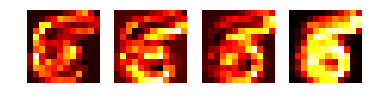

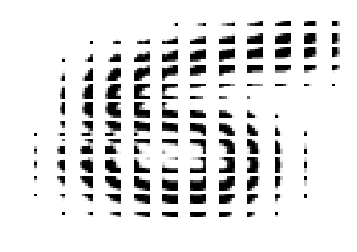

pred probability = [[ 0  0  5 17  0 76  0  0  0  0]]
pred number      = 5
continue? or end? = 

Random data set 4224
Test set label   = [0 0 0 0 0 0 0 0 0 1]


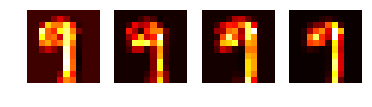

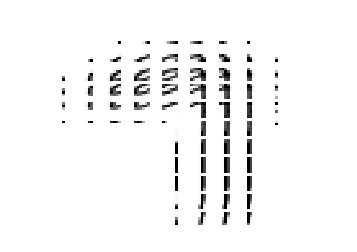

pred probability = [[ 0  0  0  2  4  0  0 26  0 66]]
pred number      = 9
continue? or end? = 

Random data set 1894
Test set label   = [0 0 0 0 0 0 0 0 0 1]


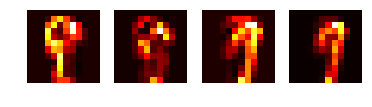

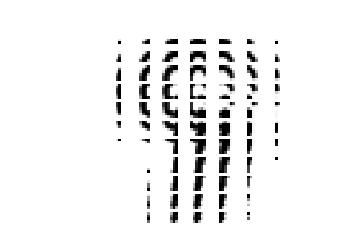

pred probability = [[ 0  0  0  1  0  5  0 30  0 61]]
pred number      = 9
continue? or end? = 

Random data set 7444
Test set label   = [0 0 0 0 0 0 0 0 1 0]


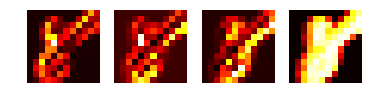

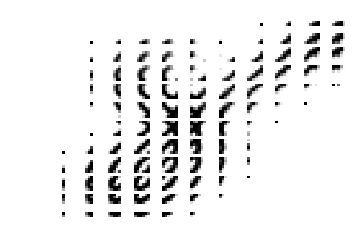

pred probability = [[ 0  0  0  0  0  0 14  0 83  0]]
pred number      = 8
continue? or end? = 

Random data set 793
Test set label   = [0 0 0 0 0 0 0 0 1 0]


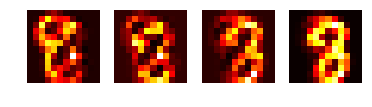

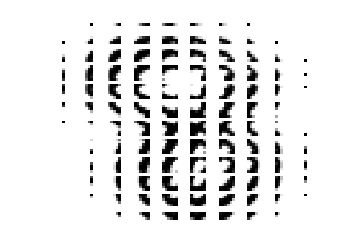

pred probability = [[ 0  0  0  0  0  0  0  0 98  0]]
pred number      = 8
continue? or end? = 

Random data set 6916
Test set label   = [0 0 0 0 0 0 0 0 0 1]


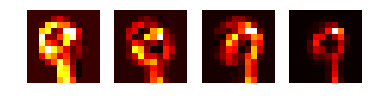

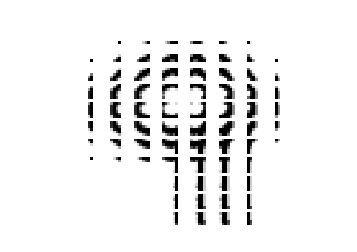

pred probability = [[ 0  0  0  1  0  0  0  1  0 96]]
pred number      = 9
continue? or end? = 

Random data set 3059
Test set label   = [0 0 0 0 0 0 0 1 0 0]


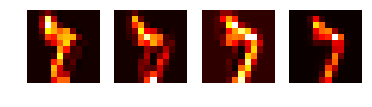

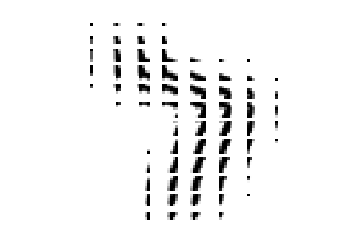

pred probability = [[ 0  8  1  0  0  3  0 84  0  0]]
pred number      = 7
continue? or end? = 

Random data set 9127
Test set label   = [0 0 0 0 0 0 1 0 0 0]


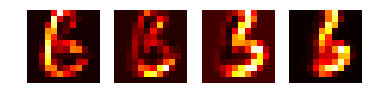

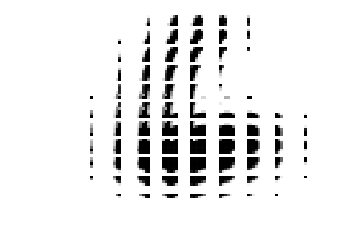

pred probability = [[ 0  0  0  0  0  0 99  0  0  0]]
pred number      = 6
continue? or end? = 

Random data set 8935
Test set label   = [0 0 0 0 0 0 0 0 0 1]


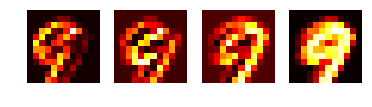

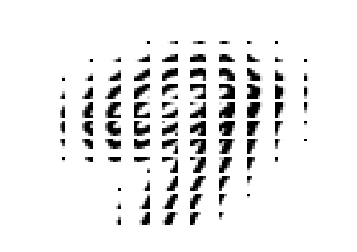

pred probability = [[ 0  0  0  0  0  0  0  0  0 99]]
pred number      = 9
continue? or end? = end


In [7]:
test = 'go'
while test != 'end':
    temp_idx=np.random.randint(1,m_test)
    print('\nRandom data set '+str(temp_idx))
    print('Test set label   = '+str(np.int_(Y_test[temp_idx])))
    y_pre = sess.run(y_deep,feed_dict={x: X_test[temp_idx,:].reshape(1,784)})
    a_out = sess.run(model_a,feed_dict={x: X_test[temp_idx,:].reshape(1,784)})
    a_out = np.reshape(a_out, [window_step[0]*window_step[1], window_size, window_size])
    s1_out = sess.run(attention_s1,feed_dict={x: X_test[temp_idx,:].reshape(1,784)})
    s2_out = sess.run(attention_s2,feed_dict={x: X_test[temp_idx,:].reshape(1,784)})
    s3_out = sess.run(attention_s3,feed_dict={x: X_test[temp_idx,:].reshape(1,784)})
    s4_out = sess.run(attention_s4,feed_dict={x: X_test[temp_idx,:].reshape(1,784)})
    s1_image = np.reshape(s1_out,[window_step[0], window_step[1]])
    s2_image = np.reshape(s2_out,[window_step[0], window_step[1]])
    s3_image = np.reshape(s3_out,[window_step[0], window_step[1]])
    s4_image = np.reshape(s4_out,[window_step[0], window_step[1]])
    
#     heat_map = np.zeros([28,28])
#     for i in range(window_step[0]):
#         for j in range(window_step[1]):
#             heat_map[window_move*i:(window_move*i+window_size),window_move*j:(window_move*j+window_size)] = \
#                 heat_map[window_move*i:(window_move*i+window_size),window_move*j:(window_move*j+window_size)] + \
#                 np.ones([window_size,window_size])*s_image[i,j]
    
#     plt.imshow(heat_map/np.max(heat_map), cmap='hot')
#     plt.show()

    f1, axarr1 = plt.subplots(1,4)
    axarr1[0].imshow(s1_image, cmap='hot')
    axarr1[0].axis("off")
    axarr1[1].imshow(s2_image, cmap='hot')
    axarr1[1].axis("off")
    axarr1[2].imshow(s3_image, cmap='hot')
    axarr1[2].axis("off")
    axarr1[3].imshow(s4_image, cmap='hot')
    axarr1[3].axis("off")
    plt.show()
    
#     plt.imshow(s_image, cmap='hot')
    
    
    f, axarr = plt.subplots(window_step[0], window_step[1])
    for i in range(window_step[0]):
        for j in range(window_step[1]):
#             print(s_out[0, window_step[1]*i + j])
#             axarr[i,j].imshow(a_out[window_step[1]*i + j]*s_out[0, window_step[1]*i + j], cmap='gray_r')
            axarr[i,j].imshow(a_out[window_step[1]*i + j], cmap='gray_r')
            axarr[i,j].axis("off")

    plt.show()
    
    print('pred probability = '+str(np.int_(y_pre*100)))
    print('pred number      = '+str(np.argmax(y_pre[0,:])))
    test = input('continue? or end? = ')